In [1]:
import os, glob
import shutil
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
from scipy.integrate import simpson
from skimage.filters import gaussian
from einops.einops import rearrange

from utils.data_utils import apply_gaussian_filter, normalize_data, get_coll_points, get_tensors

In [2]:
def read_nii_folder(folder):
    scans = sorted(glob.glob(folder))
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(scans)
    image = reader.Execute()
    data_dict = {'array': sitk.GetArrayFromImage(image).astype(np.float32),
                 'spacing': image.GetSpacing(),
                 'dims': image.GetSize(),
                 'shape': sitk.GetArrayFromImage(image).shape}
    return data_dict
def load_data_AMC(gaussian_filter_type, sd=2.5,
                    folder=r'D:/PPINN_patient_data/AMCCTP/',
                    case='C102'):
    aif_location = os.path.join(folder, rf'AIF_annotations/{case}/aif.nii.gz')
    vof_location = os.path.join(folder, rf'VOF_annotations/{case}/vof.nii.gz')
    time_matrix = os.path.join(folder, rf'CTP_time_matrix/{case}/matrix.npy')
    ctp_folder = os.path.join(folder, rf'CTP_nii_registered/{case}/*.nii.gz')
    brainmask = os.path.join(folder, rf'CTP_nii_brainmask/{case}/brainmask.nii.gz')
    # load image data
    image_data_dict = read_nii_folder(ctp_folder)
    # load time matrix
    time_data = np.load(time_matrix)
    # load aif and vof locations
    aif_location = sitk.GetArrayFromImage(sitk.ReadImage(aif_location))
    vof_location = sitk.GetArrayFromImage(sitk.ReadImage(vof_location))
    time_aif_location = list(set(np.where(aif_location == 1)[0]))[0]
    time_vof_location = list(set(np.where(vof_location == 1)[0]))[0]
    # load brainmask
    brainmask_data = sitk.GetArrayFromImage(sitk.ReadImage(brainmask))
    # image_data_dict['array'] = np.multiply(image_data_dict['array'], brainmask_data)
    # get aif and vof data
    aif_data = np.sum(np.multiply(aif_location, image_data_dict['array']), axis=(1,2,3)) / np.sum(aif_location)
    vof_data = np.sum(np.multiply(vof_location, image_data_dict['array']), axis=(1,2,3)) / np.sum(vof_location)
    aif_time_data = time_data[time_aif_location]
    vof_time_data = time_data[time_vof_location]
    plt.plot(aif_data, label=case)
    plt.plot(vof_data)
    plt.legend()
    plt.show()
    image_data_dict['array'] = np.multiply(image_data_dict['array'], brainmask_data)

    # scale aif
    # vof_baseline = np.mean(vof_data[:4])
    # aif_baseline = np.mean(aif_data[:4])
    # aif_wo_baseline = aif_data - aif_baseline
    # vof_wo_baseline = vof_data - vof_baseline
    # # now we use simpsons approximation because of irregular timing
    # cumsum_aif = simpson(aif_wo_baseline, aif_time_data)
    # cumsum_vof = simpson(vof_wo_baseline, vof_time_data)
    # ratio = cumsum_vof / cumsum_aif
    # aif_data = aif_wo_baseline * ratio + aif_baseline
    # # If smoothing, apply here
    # if gaussian_filter_type:
    #     image_data_dict['array'] = apply_gaussian_filter(gaussian_filter_type, image_data_dict['array'].copy(), sd=sd)
    # image_data_dict['array'] = image_data_dict['array'].astype(np.float32)
    # image_data_dict['array'] = rearrange(image_data_dict['array'], 't d h w -> d h w t')
    # # get high res time sample for plotting purposes
    # time_inference_highres = np.array([float(x) for x in np.arange(np.min(time_data), np.max(time_data), 0.1)])
    #
    #
    # data_dict = {'aif': aif_data,
    #              'vof': vof_data,
    #              'time': time_data,
    #              'time_inference_highres': time_inference_highres,
    #              'curves': image_data_dict['array'],
    #              'brainmask': brainmask_data}
    #
    # data_dict = normalize_data(data_dict)
    # data_dict = get_coll_points(data_dict)
    # data_dict = get_tensors(data_dict)
    return 0

C102
C103
C104
C105
C106
C107
C108
C109
C110
C111
C112
C113
C114
C115
C116


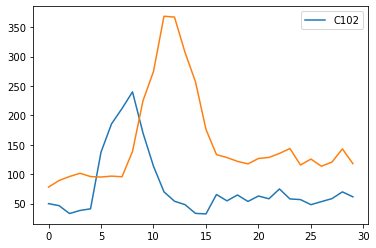

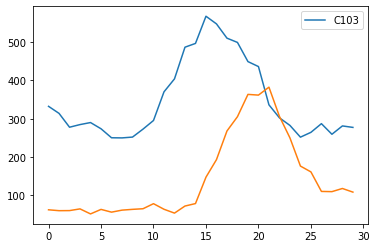

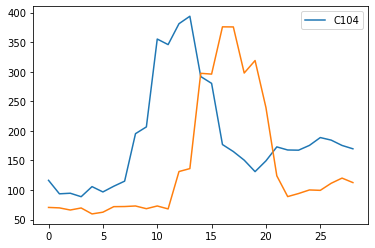

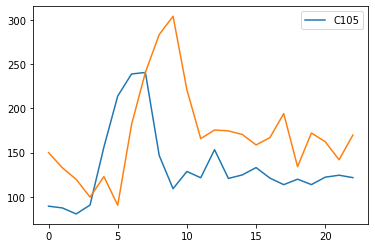

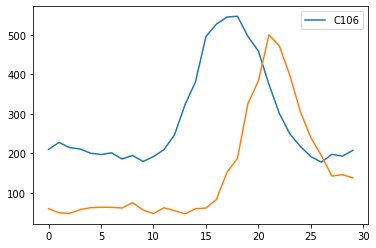

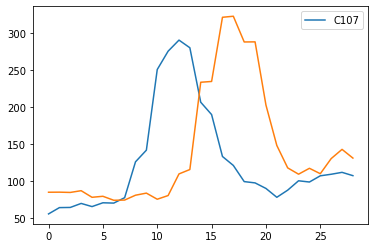

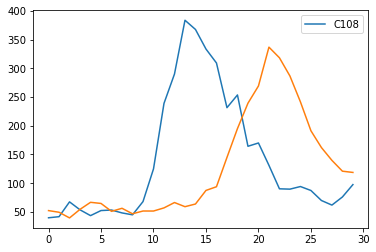

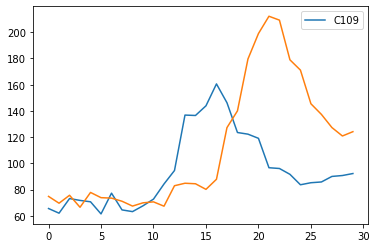

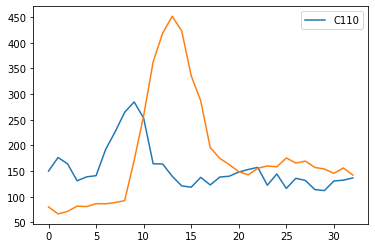

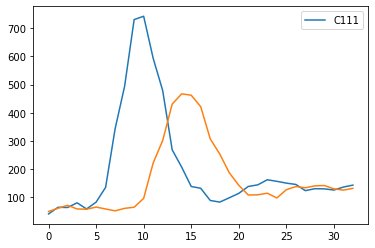

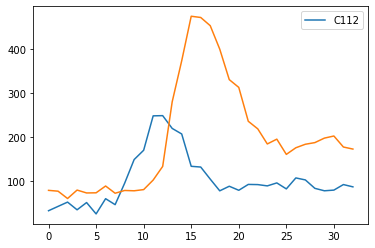

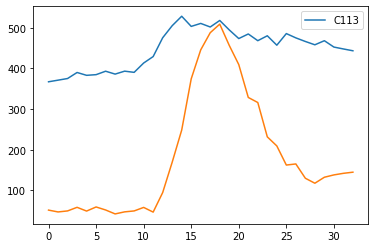

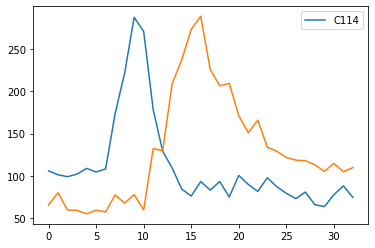

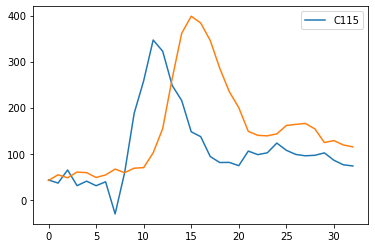

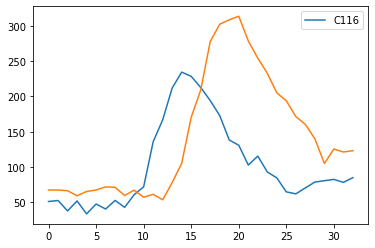

In [3]:
cases = ['C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116']
for case in cases:
    print(case)
    load_data_AMC('gauss_spatial', case=case)